In [1]:
#show path
import sys
sys.path.append('../')

In [2]:
import pandas as pd
import glob
import ComputationalHypergraphDiscovery as CHD
import jax
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import jax.numpy as np

# Recover the data and reconstruct the graph found by CHD

In [3]:

df=pd.read_csv('./data_and_results/BCR.csv')
targets=df.columns[1122:]
cut=2400
df_train=df[:cut]
df_test=df[cut:]
df

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,$/partial_t S1112$,$/partial_t S1113$,$/partial_t S1114$,$/partial_t S1115$,$/partial_t S1116$,$/partial_t S1117$,$/partial_t S1118$,$/partial_t S1119$,$/partial_t S1120$,$/partial_t S1121$
0,0.000002,7.304403e+05,585317.631604,3.615158e+06,6.195899e+06,238895.045577,8.643072e-10,15248.430999,166357.589035,6.986633e-10,...,3.475410e-03,1.443360e-07,3.354071e-05,2.561977e-04,7.731132e+01,2.031811e-02,1.493338e+02,3.616471e+02,4.624753e-03,8.947311e-02
1,0.000002,8.655895e+05,710888.179756,3.574970e+06,6.491118e+06,242966.103845,1.121930e-09,15863.426978,175871.708328,9.284568e-10,...,1.699553e-03,9.848641e-08,1.868933e-05,1.695635e-04,9.745335e+01,1.961951e-02,1.264184e+02,3.378304e+02,5.203614e-03,1.103019e-01
2,119649.797101,1.153809e+05,115380.207169,1.112686e+05,1.199996e+05,119999.999716,1.380535e+02,1.361351,2.606950,1.380527e+02,...,7.076956e-12,2.232804e-25,8.339580e-18,1.121754e-16,1.250482e-06,2.413633e-13,3.161855e-05,7.004705e-05,2.528237e-15,1.247526e-09
3,119700.023569,1.154077e+05,115407.275307,1.112727e+05,1.200000e+05,119999.999968,1.381435e+02,1.247712,1.960094,1.381430e+02,...,3.351184e-12,1.419783e-25,2.645328e-19,4.152657e-17,1.089697e-05,1.243332e-13,3.787004e-06,1.660261e-05,3.995675e-14,1.085608e-08
4,29981.379311,2.969648e+04,29696.495350,2.941458e+04,3.000000e+04,30000.000000,8.903415e+00,0.141142,0.175124,8.903421e+00,...,2.161153e-14,7.088757e-29,7.795995e-22,1.058060e-19,9.732877e-09,2.788445e-16,1.478142e-07,3.238233e-07,4.869930e-18,9.709106e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000,0.000002,1.115007e+06,974531.302015,3.526420e+06,7.075370e+06,341835.359312,1.769014e-09,16984.587413,161878.040296,1.554103e-09,...,2.343143e-04,2.910494e-08,2.970329e-06,5.085564e-05,1.635863e+02,1.075838e-02,4.861911e+01,2.130331e+02,5.524407e-03,1.715411e-01
5001,297148.127742,2.735912e+05,273583.446419,2.519036e+05,2.999944e+05,299999.936688,8.129941e+02,4.703674,14.391908,8.129719e+02,...,1.690567e-10,3.790267e-23,1.342285e-15,7.824249e-15,4.464824e-05,1.354047e-11,6.387906e-04,1.450940e-03,2.828985e-13,4.454087e-08
5002,0.000006,1.774727e+03,1420.282767,3.076068e+06,3.791961e+06,238032.895425,9.719790e-12,5020.205605,8163.711747,8.458764e-12,...,-4.378077e-03,8.244811e-07,-2.500028e-04,-5.748210e-04,-2.049486e+01,-1.760463e-03,-3.577294e+01,-6.933246e+01,2.478592e-04,-2.077291e-02
5003,0.000006,1.772895e+03,1418.532250,3.074676e+06,3.790500e+06,238033.025601,9.717387e-12,5016.628520,8156.249045,8.455209e-12,...,-4.356279e-03,8.249133e-07,-2.500649e-04,-5.732107e-04,-2.039048e+01,-1.746116e-03,-3.585287e+01,-6.938882e+01,2.543894e-04,-2.066849e-02


In [4]:
possible_edges=nx.DiGraph()
edges=[]
for f_node in df.columns:
    if 'partial' in f_node:
        continue
    for nf_node in df.columns:
        if 'partial' in nf_node:
            edges.append((f_node,nf_node))
            edges.append((nf_node,f_node))
possible_edges.add_edges_from(edges)

graph_discovery=CHD.GraphDiscovery.from_dataframe(df_train,normalize=True,possible_edges=possible_edges,kernels=[CHD.Modes.QuadraticMode(memory_efficient_required=True)],gamma_min=1e-9)
graphs = [pickle.load(open(path, "rb")) for path in glob.glob('./data_and_results/results_all_original_BCR/*.pkl')]
for g in graphs:
    graph_discovery.G=nx.compose(graph_discovery.G,g)

Converting possible edges to dense adjacency matrix


# Compare the recovered graph and the true graph


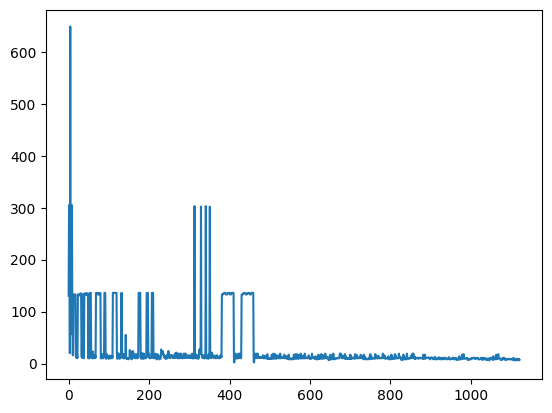

In [5]:
true_graph=pickle.load(open('./data_and_results/BCR.pkl','rb'))
ancestors=np.array([len(nx.ancestors(true_graph,node)) for node in targets])
plt.plot(ancestors)
plt.show()

In [6]:
#compute the true positives and false negatives. For each edge in graph_discovery.G, if it is in true_graph, it is a true positive, otherwise it is a false positive
#true_graph is a networkx graph, graph_discovery.G is a networkx graph
true_positives=0
false_positives=0
false_negatives=0
true_negatives=0
for edge in graph_discovery.G.edges:
    if edge in true_graph.edges:
        true_positives+=1
    else:
        false_positives+=1

for edge in true_graph.edges:
    if edge not in graph_discovery.G.edges:
        if edge[1] in targets and len(nx.ancestors(true_graph,edge[1]))<69:
            false_negatives+=1
#compute true negatives
true_negatives=len(true_graph.edges)-true_positives

false_negatives
print('false positive rate:',false_positives/(false_positives+true_positives))
print('false negative rate:',false_negatives/(false_negatives+true_positives))
print('true positive rate:',true_positives/(false_negatives+true_positives))
print('true negative rate:',true_negatives/(false_positives+true_negatives))
print('false discovery rate:',false_positives/(false_positives+true_positives))

false positive rate: 0.9722698589369396
false negative rate: 0.6009486492060219
true positive rate: 0.39905135079397813
true negative rate: 0.11615323820359386
false discovery rate: 0.9722698589369396


In [7]:
true_positives

5805

In [8]:
false_positives

203534

In [9]:
false_negatives

8742

This result is quite unsatisfactory, as our recovered graph is far from the true graph. We will now look at the accuracy of our recovery to see if we still get good results to predict the variables of the graph. 

# Computing the accuracy of the recovery

In [10]:
active_mode_dic = nx.get_node_attributes(graph_discovery.G, "active_modes")
for node,active_mode in active_mode_dic.items():
    missing=graph_discovery.X.shape[1]-active_mode.shape[0]
    graph_discovery.G.nodes[node]["active_modes"] =jax.numpy.pad(active_mode,(0,missing),'constant',constant_values=(0,0))

In [11]:
# Serialize the graph discovery object
import joblib
joblib.dump(graph_discovery, "BCR.pkl")

['BCR.pkl']

In [12]:
pred = graph_discovery.predict(targets,df_test.values)
truth=df_test[targets].values
std=np.std(truth,axis=0)
errors= jax.numpy.quantile((truth-pred)**2,0.99,axis=0)/std**2

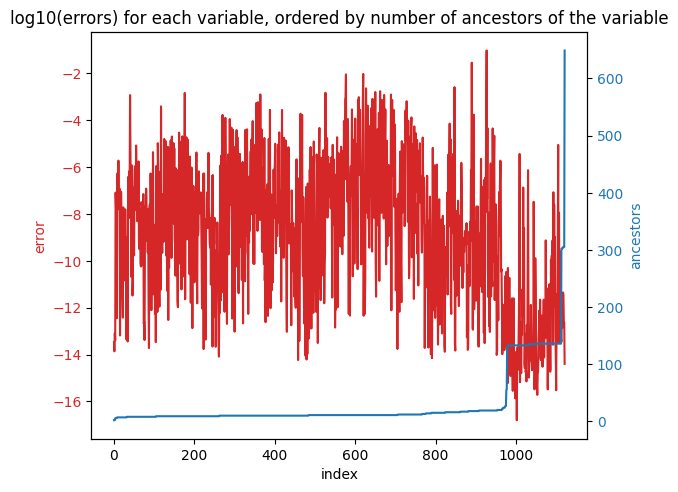

In [13]:
#plot two plots with different y axis
fig, ax1 = plt.subplots()
indexes=np.argsort(ancestors)

color = 'tab:red'
ax1.set_xlabel('index')
ax1.set_ylabel('error', color=color)
ax1.plot(np.log10(errors)[indexes], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('ancestors', color=color)  # we already handled the x-label with ax1
ax2.plot((ancestors)[indexes], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('log10(errors) for each variable, ordered by number of ancestors of the variable')
plt.show()

The error seems to depend very little on the true number of ancestors. When looking at the errors per sample, we notice that there is a few outliers that are the cause of most of the observed error. 

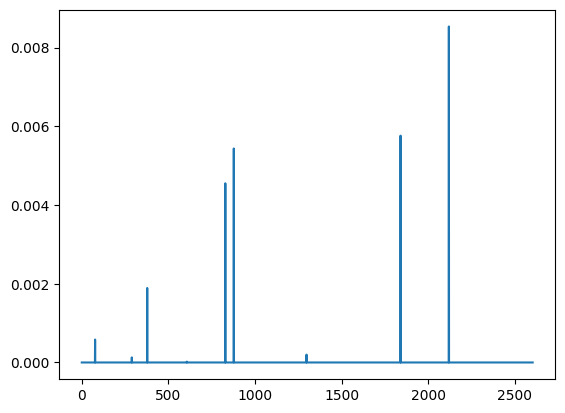

In [14]:
errors_per_sample= jax.numpy.median((truth-pred)**2/std[None,:]**2,axis=1)
plt.plot(errors_per_sample)

# No pruning
We may now compare the accuracy we got to the accuracy one gets without pruning. 

In [15]:
active_mode = np.array([1]*(graph_discovery.X.shape[1]//2)+[0]*(graph_discovery.X.shape[1]//2))
K_mat=graph_discovery.kernels[0](graph_discovery.X,graph_discovery.X,active_mode)
gamma=100
ybs=jax.scipy.linalg.solve(K_mat+gamma*np.eye(K_mat.shape[0]),graph_discovery.X,assume_a='pos')
ybs=ybs[:,1122:]

In [16]:
normalized_test_values=(df_test.values- graph_discovery.mean_x) / graph_discovery.std_x
K_pred=graph_discovery.kernels[0](normalized_test_values,graph_discovery.X,active_mode)
pred_no_pruning=K_pred@ybs
pred_no_pruning=(pred_no_pruning*graph_discovery.std_x[:,1122:])+graph_discovery.mean_x[:,1122:]
diffs_no_pruning=(df_test[targets].values-pred_no_pruning)

Pruning improves the accuracy of the recovery

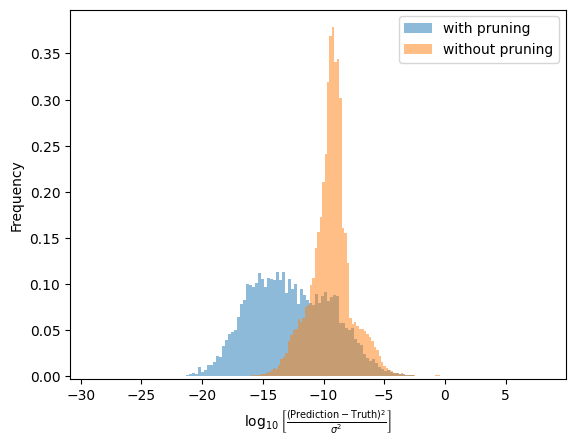

In [17]:
pruning_errors=((truth-pred)**2/std**2).flatten()
no_pruning_errors=((diffs_no_pruning)**2/std**2).flatten()

plt.hist(np.log10(pruning_errors),bins=150,alpha=0.5,label='with pruning',density=True)
plt.hist(np.log10(no_pruning_errors),bins=150,alpha=0.5,label='without pruning',density=True)

plt.xlabel('$\\log_{10}\\left[\\frac{(\\text{Prediction}-\\text{Truth})^2}{\\sigma^2}\\right]$')
plt.ylabel('Frequency')
plt.ylim(bottom=-0.003)
plt.legend()
plt.show()



In [18]:
f"{(1-np.sum(pruning_errors>no_pruning_errors)/len(pruning_errors))*100:.1f}% of samples have a  error with pruning"

'83.4% of samples have a  error with pruning'

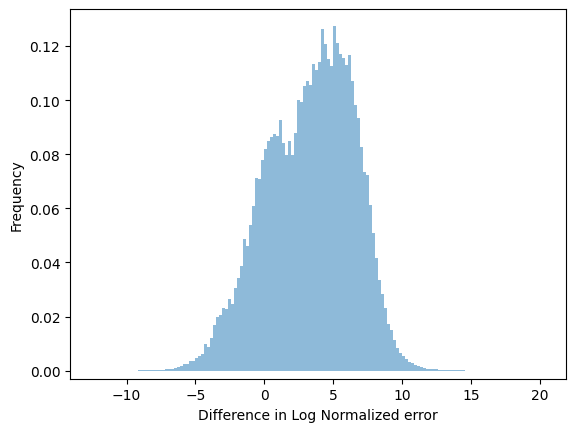

In [19]:
pruning_errors=((truth-pred)**2/std**2).flatten()
no_pruning_errors=((diffs_no_pruning)**2/std**2).flatten()

plt.hist(np.log10(no_pruning_errors)-np.log10(pruning_errors),bins=150,alpha=0.5,label='with pruning',density=True)


plt.xlabel('Difference in Log Normalized error')
plt.ylabel('Frequency')
plt.ylim(bottom=-0.003)
#plt.legend()
plt.show()